In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import nltk
#nltk.download('stopwords')
#nltk.download(['punkt', 'wordnet'])
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re

In [2]:
# Read a table of fixed-width formatted lines into DataFrame.
df = pd.read_fwf('text_to_cluster.txt',header=None,names=['Text_data']) 

In [3]:
print(df)

                                             Text_data
0    Ransomware attack at Mexico's Pemex halts work...
1    #city | #ransomware | Ransomware Attack At Mex...
2    Mexico's Pemex Oil Suffers Ransomware Attack, ...
3    A Mexican oil company was hit by ransomware at...
4                    Pemex Struck by Ransomware Attack
..                                                 ...
679             Detecting and Responding to Ransomware
680   Emotet malware is back, more dangerous than ever
681  Hosting provider SmarterASP.NET hit by ransomw...
682  Ransomware as a Service (RaaS) – A Contemporar...
683  Ransomware as a Service (RaaS) – A Contemporar...

[684 rows x 1 columns]


In [4]:
df['Text_data'][1]

'#city | #ransomware | Ransomware Attack At Mexico’s Pemex Halts Work, Threatens To Cripple Computers'

In [5]:
df = pd.DataFrame(df)

In [6]:
df

,Text_data
0,Ransomware attack at Mexico's Pemex halts work...
1,#city | #ransomware | Ransomware Attack At Mex...
2,"Mexico's Pemex Oil Suffers Ransomware Attack, ..."
3,A Mexican oil company was hit by ransomware at...
4,Pemex Struck by Ransomware Attack
...,...
679,Detecting and Responding to Ransomware
680,"Emotet malware is back, more dangerous than ever"
681,Hosting provider SmarterASP.NET hit by ransomw...
682,Ransomware as a Service (RaaS) – A Contemporar...


In [7]:
import nltk
from nltk.corpus import stopwords
from typing import List, Dict

In [8]:
def preprocess_text(text: str, remove_stopwords: bool) -> List[str]:
    """This utility function sanitizes a string by:
    - removing links
    - removing special characters
    - removing numbers
    - removing stopwords
    - transforming in lowercase
    - removing excessive whitespaces
    Args:
        text (str): the input text you want to clean
        remove_stopwords (bool): whether or not to remove stopwords
    Returns:
        str: the cleaned text
    """

    # Remove links
    text = re.sub(r"http\S+", "", text)
    
    # remove special chars and numbers
    text = re.sub("[^A-Za-z]+", " ", text)
    
    # remove stopwords
    if remove_stopwords:
        # 1. tokenize
        tokens = nltk.word_tokenize(text)
        
        # 2. check if stopword
        tokens = [w for w in tokens if not w.lower() in stopwords.words("english")]
        
        # 3. join back together
        text = " ".join(tokens)
        
    # return text in lower case and stripped of whitespaces
    text = text.lower().strip()
    return text


In [9]:
df['Cleaned_Data'] = df['Text_data'].apply(lambda x: preprocess_text(x, remove_stopwords=True))
df

,Text_data,Cleaned_Data
0,Ransomware attack at Mexico's Pemex halts work...,ransomware attack mexico pemex halts work thre...
1,#city | #ransomware | Ransomware Attack At Mex...,city ransomware ransomware attack mexico pemex...
2,"Mexico's Pemex Oil Suffers Ransomware Attack, ...",mexico pemex oil suffers ransomware attack mil...
3,A Mexican oil company was hit by ransomware at...,mexican oil company hit ransomware attack
4,Pemex Struck by Ransomware Attack,pemex struck ransomware attack
...,...,...
679,Detecting and Responding to Ransomware,detecting responding ransomware
680,"Emotet malware is back, more dangerous than ever",emotet malware back dangerous ever
681,Hosting provider SmarterASP.NET hit by ransomw...,hosting provider smarterasp net hit ransomware...
682,Ransomware as a Service (RaaS) – A Contemporar...,ransomware service raas contemporary mal du si...


In [10]:
def build_corpus(df):
    corpus = []
    for sentence in df.iteritems():
        word_list = sentence[1].split(" ")
        corpus.append(word_list)
    return corpus

corpus = build_corpus(df['Cleaned_Data'])
corpus[0]

['ransomware',
 'attack',
 'mexico',
 'pemex',
 'halts',
 'work',
 'threatens',
 'cripple',
 'computers']

In [11]:
from gensim.models import Word2Vec
model = Word2Vec(corpus, vector_size=100, min_count=1)

In [12]:
model.wv.most_similar("ransomware")

[('breach', 0.7105282545089722),
 ('malware', 0.7023881673812866),
 ('attack', 0.6994503140449524),
 ('security', 0.6689013242721558),
 ('data', 0.6461064219474792),
 ('provider', 0.640939474105835),
 ('cisco', 0.6385257244110107),
 ('new', 0.6303470134735107),
 ('zero', 0.6222521066665649),
 ('phishing', 0.6168829798698425)]

In [13]:
def create_vectors(docs: List[List[str]]) -> List[List[float]]:
    all_vectors = []

    for text_tokens in docs:
        zero_vector = np.zeros(model.vector_size)
        vectors = []
        for token in text_tokens:
            if token in model.wv:
                try:
                    vectors.append(model.wv[token])
                except KeyError:
                    continue
        if vectors:
            vectors = np.asarray(vectors)
            avg_vector = vectors.mean(axis=0)
            all_vectors.append(avg_vector)
        else:
            all_vectors.append(zero_vector)
    return all_vectors

In [14]:
all_text_vectors = create_vectors(corpus)

In [15]:
all_text_vectors[0]

array([-6.7537823e-03,  4.5274533e-03,  2.7518470e-03,  4.6799565e-03,
       -3.1828668e-03, -1.6362423e-02,  2.7258520e-03,  1.7004173e-02,
       -8.5929297e-03, -8.2736788e-03, -2.5372731e-04, -1.2003892e-02,
       -7.5024390e-03,  5.6113349e-03,  3.0772560e-03, -2.6140094e-03,
        5.8172108e-04, -2.4689145e-03, -8.7363314e-04, -9.3749883e-03,
        3.8696742e-03,  1.0828709e-03,  5.7000238e-03, -5.4828096e-03,
        1.1807124e-03,  3.9077196e-03, -7.7999700e-03, -5.8659967e-03,
       -6.3998122e-03,  2.4185509e-03,  7.3152389e-03,  4.3300539e-03,
        8.8996701e-03, -3.9008658e-03, -3.8160549e-03,  5.7967240e-03,
        8.7773305e-04, -1.3909056e-03, -3.5770035e-03, -1.1444869e-02,
        1.9651863e-03, -3.1003756e-03, -1.7337131e-03, -1.5826873e-03,
        2.1900944e-03, -3.5658805e-03, -3.7873064e-03, -2.0652275e-04,
        9.0529071e-03,  3.4424274e-03, -3.3981157e-03, -5.2213776e-03,
        2.0636903e-04, -5.7710614e-04, -4.8140861e-04,  1.5371894e-03,
      

In [16]:
len(all_text_vectors[0])

100

In [17]:
from sklearn.cluster import KMeans
kmeans_model = KMeans(n_clusters=6).fit(all_text_vectors)

In [18]:
df["cluster_label"] = kmeans_model.labels_

In [19]:
df.head()

,Text_data,Cleaned_Data,cluster_label
0,Ransomware attack at Mexico's Pemex halts work...,ransomware attack mexico pemex halts work thre...,3
1,#city | #ransomware | Ransomware Attack At Mex...,city ransomware ransomware attack mexico pemex...,3
2,"Mexico's Pemex Oil Suffers Ransomware Attack, ...",mexico pemex oil suffers ransomware attack mil...,3
3,A Mexican oil company was hit by ransomware at...,mexican oil company hit ransomware attack,3
4,Pemex Struck by Ransomware Attack,pemex struck ransomware attack,3


In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer 
# initialize the vectorizer
vectorizer = TfidfVectorizer(sublinear_tf=True,min_df=5, max_df=0.95)
# fit_transform applies TF-IDF to clean texts - we save the array of vectors in X
X = vectorizer.fit_transform(df['Cleaned_Data']).toarray()
X = X.reshape(-1,1)

In [21]:
X

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])

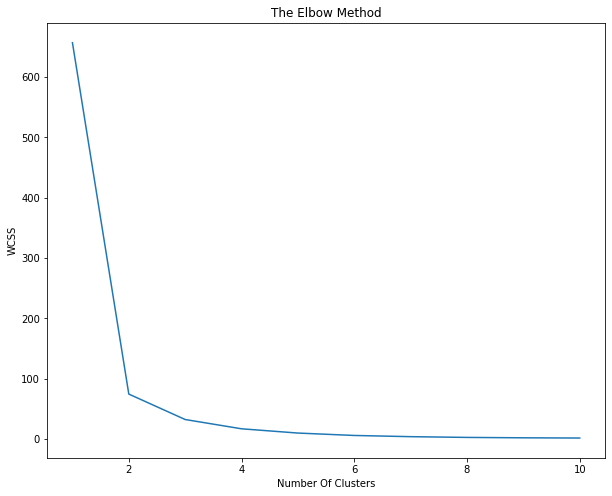

In [22]:
#finding optimal number of clusters using the elbow method  

from sklearn.cluster import KMeans  
fig = plt.figure(figsize=(10,8)) 

WCSS = []   # Initializing the list for the values of WCSS  
  
#Using for loop for iterations from 1 to 10.  
for i in range(1, 11):  
    clf = KMeans(n_clusters=i)
    clf.fit(X)
    WCSS.append(clf.inertia_) #inertia is another name for WCSS
    
plt.plot(range(1, 11), WCSS)  
plt.title('The Elbow Method')  
plt.ylabel('WCSS')
plt.xlabel('Number Of Clusters') 
plt.show()  


In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer 
# initialize the vectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, max_df=0.95)
# fit_transform applies TF-IDF to clean texts - we save the array of vectors in X
X = tfidf.fit_transform(df['Cleaned_Data'])

In [24]:

from sklearn.cluster import KMeans

# initialize kmeans 
kmeans = KMeans(n_clusters=4, random_state=42)
# fit the model
kmeans.fit(X)
# store cluster labels in a variable
clusters = kmeans.labels_

In [25]:
df['Cleaned_Data'][1]

'city ransomware ransomware attack mexico pemex halts work threatens cripple computers'

##### I used PCA because it reduces the dependency ,improves the result , reduces overfitting problem and which helps in reducing dimensions and dimension reduction helps in visualisation easily

In [26]:
from sklearn.decomposition import PCA

# initialize PCA with 2 components
pca = PCA(n_components=2, random_state=42)
# pass our X to the pca and store the reduced vectors into pca_vecs
pca_vecs = pca.fit_transform(X.toarray())
# save our two dimensions into x0 and x1
x0 = pca_vecs[:, 0]
x1 = pca_vecs[:, 1]

In [27]:
# assign clusters and pca vectors to our dataframe 
df['Cluster'] = clusters
df['x0'] = x0
df['x1'] = x1

In [28]:
df

,Text_data,Cleaned_Data,cluster_label,Cluster,x0,x1
0,Ransomware attack at Mexico's Pemex halts work...,ransomware attack mexico pemex halts work thre...,3,3,-0.039890,-0.187519
1,#city | #ransomware | Ransomware Attack At Mex...,city ransomware ransomware attack mexico pemex...,3,3,-0.061704,-0.213003
2,"Mexico's Pemex Oil Suffers Ransomware Attack, ...",mexico pemex oil suffers ransomware attack mil...,3,3,-0.029841,-0.216264
3,A Mexican oil company was hit by ransomware at...,mexican oil company hit ransomware attack,3,3,0.031500,-0.322368
4,Pemex Struck by Ransomware Attack,pemex struck ransomware attack,3,3,0.020250,-0.356376
...,...,...,...,...,...,...
679,Detecting and Responding to Ransomware,detecting responding ransomware,3,3,-0.221532,-0.410843
680,"Emotet malware is back, more dangerous than ever",emotet malware back dangerous ever,0,0,-0.112642,0.056622
681,Hosting provider SmarterASP.NET hit by ransomw...,hosting provider smarterasp net hit ransomware...,1,3,0.026993,-0.407248
682,Ransomware as a Service (RaaS) – A Contemporar...,ransomware service raas contemporary mal du si...,0,3,-0.096037,-0.057378


In [29]:
def get_top_keywords(n_terms):
    """This function returns the keywords for each centroid of the KMeans"""
    df = pd.DataFrame(X.todense()).groupby(clusters).mean() # groups the TF-IDF vector by cluster
    terms = vectorizer.get_feature_names_out() # access tf-idf terms
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([terms[t] for t in np.argsort(r)[-n_terms:]])) # for each row of the dataframe, find the n terms that have the highest tf idf score
            
get_top_keywords(10)


Cluster 0
emotet,users,ddos,mass,cybersecurity,cve,security,attacks,phishing,malware

Cluster 1
social,another,one,capital,chief,facebook,business,purcellville,data,breach

Cluster 2
hit,sophisticated,uk,large,scale,ddos,attack,party,cyber,labour

Cluster 3
service,hosting,provider,smarterasp,oil,new,pemex,net,attack,ransomware


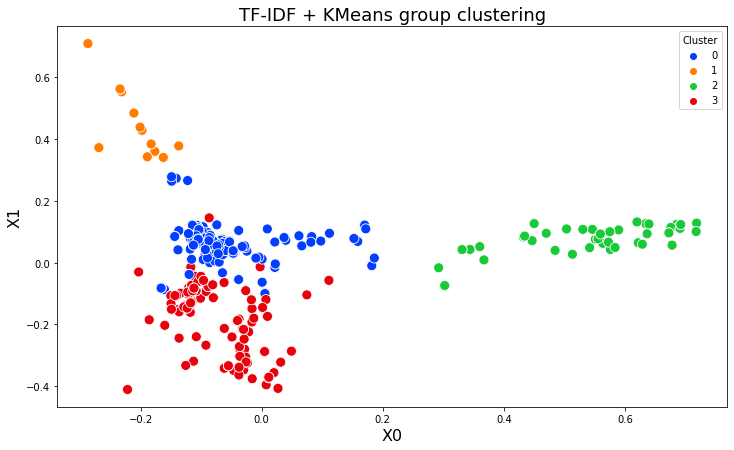

In [30]:
# set image size
plt.figure(figsize=(12, 7))
# set a title
plt.title("TF-IDF + KMeans group clustering", fontdict={"fontsize": 18})
# set axes names
plt.xlabel("X0", fontdict={"fontsize": 16})
plt.ylabel("X1", fontdict={"fontsize": 16})
# create scatter plot with seaborn, where hue is the class used to group the data
sns.scatterplot(data=df, x='x0', y='x1',s=100, hue='Cluster', palette="bright")
plt.show()

In [31]:
df

,Text_data,Cleaned_Data,cluster_label,Cluster,x0,x1
0,Ransomware attack at Mexico's Pemex halts work...,ransomware attack mexico pemex halts work thre...,3,3,-0.039890,-0.187519
1,#city | #ransomware | Ransomware Attack At Mex...,city ransomware ransomware attack mexico pemex...,3,3,-0.061704,-0.213003
2,"Mexico's Pemex Oil Suffers Ransomware Attack, ...",mexico pemex oil suffers ransomware attack mil...,3,3,-0.029841,-0.216264
3,A Mexican oil company was hit by ransomware at...,mexican oil company hit ransomware attack,3,3,0.031500,-0.322368
4,Pemex Struck by Ransomware Attack,pemex struck ransomware attack,3,3,0.020250,-0.356376
...,...,...,...,...,...,...
679,Detecting and Responding to Ransomware,detecting responding ransomware,3,3,-0.221532,-0.410843
680,"Emotet malware is back, more dangerous than ever",emotet malware back dangerous ever,0,0,-0.112642,0.056622
681,Hosting provider SmarterASP.NET hit by ransomw...,hosting provider smarterasp net hit ransomware...,1,3,0.026993,-0.407248
682,Ransomware as a Service (RaaS) – A Contemporar...,ransomware service raas contemporary mal du si...,0,3,-0.096037,-0.057378


In [32]:
df['Cleaned_Data'][575]

'isro confirms alerted dtrack malware chandrayaan says impact'

In [33]:
y = vectorizer.transform(["city ransomware ransomware attack mexico pemex halts work threatens cripple computers"])
prediction = kmeans.predict(y)
print(prediction)

[3]


In [34]:
df1 = df.iloc[:,1:3]

In [35]:
df1.sample(10)

,Cleaned_Data,cluster_label
377,ddos attacks q,0
92,intel cascade lake cpus impacted new zombieloa...,4
422,labour party hit cyber attack ahead election,2
337,prepare ransomware attack,1
480,emotet malware back dangerous ever,0
639,zimperium z detected unknown mobile malware ov...,4
103,data breach fines working boost consumer safety,0
567,researchers uncover mass malware attack,2
49,capital one replaces security chief data breach,0
254,major asp net hosting provider smarterasp hit ...,1


In [36]:
key = "attack"
y = vectorizer.transform([key])
prediction = kmeans.predict(y)
#prediction = prediction.tolist()
for i in df['Cleaned_Data']:
    if key in i:
        print('Cluster_id is:',prediction,"\nThe keyword is:",key, "\nSentence is:",i)

Cluster_id is: [3] 
The keyword is: attack 
Sentence is: ransomware attack mexico pemex halts work threatens cripple computers
Cluster_id is: [3] 
The keyword is: attack 
Sentence is: city ransomware ransomware attack mexico pemex halts work threatens cripple computers
Cluster_id is: [3] 
The keyword is: attack 
Sentence is: mexico pemex oil suffers ransomware attack million demanded
Cluster_id is: [3] 
The keyword is: attack 
Sentence is: mexican oil company hit ransomware attack
Cluster_id is: [3] 
The keyword is: attack 
Sentence is: pemex struck ransomware attack
Cluster_id is: [3] 
The keyword is: attack 
Sentence is: mexico pemex said quickly neutralized digital attack
Cluster_id is: [3] 
The keyword is: attack 
Sentence is: ransomware attack hits mexican state oil firm pemex
Cluster_id is: [3] 
The keyword is: attack 
Sentence is: ransomware attack mexican state oil firm halts work threatens cripple computers getaps site
Cluster_id is: [3] 
The keyword is: attack 
Sentence is: m

In [37]:
import re

In [38]:
cve_pattern = r'CVE-\d{4}-\d{4,7}'